<a href="https://colab.research.google.com/github/jeonghojo00/SpeechRecognition/blob/main/LibriSpeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Set up

In [1]:
!nvidia-smi

Wed Nov  9 15:23:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    47W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import torch
import pickle
import random
import torchaudio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from datetime import timedelta


# Audio Processing
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

# Pytorch libraries for models and data input
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence

import torchvision
from torchvision import models
from torchvision.transforms import transforms, ToTensor

import torchaudio
# https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch/

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Change directory to the package folder
%cd '/content/drive/MyDrive/Colab Notebooks/DB/LibriSpeech'
# Verify the contents of the current folder
!ls

/content/drive/MyDrive/Colab Notebooks/DB/LibriSpeech
LibriSpeech
LibriSpeech_ImprovedDS2_dsc_model.pt
LibriSpeech_ImprovedDS2_dsc_res.pkl
LibriSpeech_ImprovedDS2_model.pt
LibriSpeech_ImprovedDS2_nodsc_reduced_RnnDim.pkl
LibriSpeech_ImprovedDS2_nodsc_reduced_RnnDim.pt
LibriSpeech_ImprovedDS2_res.pkl
test-clean.tar.gz


In [5]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(3407)
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

#1. Data Preparation

## 1_1. Import Dataset

In [6]:
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

## 1_2. Data Exploratoin

In [7]:
data_1 = train_dataset[0]
print(f"waveform.    : {data_1[0]}")
print(f"sample_rate  : {data_1[1]}")
print(f"utterance    : {data_1[2][:85]}...")
print(f"speaker_id   : {data_1[3]}")
print(f"chapter_id   : {data_1[4]}")
print(f"utterance_id : {data_1[5]}")
# waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id
print(f"\nData waveform has a shape of {data_1[0].shape}")

waveform.    : tensor([[-0.0065, -0.0055, -0.0062,  ...,  0.0033,  0.0005, -0.0095]])
sample_rate  : 16000
utterance    : CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE...
speaker_id   : 103
chapter_id   : 1240
utterance_id : 0

Data waveform has a shape of torch.Size([1, 225360])


In [8]:
from IPython.core.display import display

def waveplot(a_data):
    '''
    This function displays a wave form of an audio file
    sr = sample rate
    '''
    y = a_data[0].numpy().squeeze(0)
    sr = a_data[1]
    captions = a_data[2]

    plt.figure(figsize=(10,4))
    librosa.display.waveplot(y, sr = sr)
    plt.show()

def spectogram(a_data):
    '''
    This function displays a spectogram of an audio file
    sr = sample rate
    '''
    y = a_data[0].numpy().squeeze(0)
    sr = a_data[1]
    captions = a_data[2]

    x = librosa.stft(y)
    xdb = librosa.amplitude_to_db(x) # x into decibel
    plt.figure(figsize=(10,4))
    librosa.display.specshow(xdb, sr = sr, x_axis='time', y_axis='hz')
    plt.colorbar()

def playSound(a_data):
    
    speaker_id = str(a_data[3])
    chapter_id = str(a_data[4])
    utterance_id = str(a_data[5])

    train_path = './LibriSpeech/train-clean-100'
    file_numbering = '0'*(4-len(utterance_id)) + utterance_id
    file_path = train_path + f'/{speaker_id}/{chapter_id}/{speaker_id}-{chapter_id}-{file_numbering}.flac'
    display(Audio(filename = file_path))

def printCaption(a_data):
    a_caption = a_data[2]
    a_caption = a_caption.split()
    board = []
    words = ""
    num_words = 0
    for i in range(len(a_caption)):
        words = words + " " + a_caption[i]
        num_words += 1
        if num_words == 10 or i == len(a_caption)-1:
            print(words)
            words = ""
            num_words = 0

def exploreData(a_data):
    printCaption(a_data)
    waveplot(a_data)
    spectogram(a_data)
    playSound(a_data)


 CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE
 LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO
 A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND
 TRAVERSED BY A BROOK


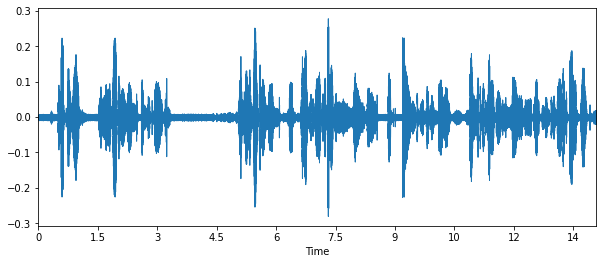

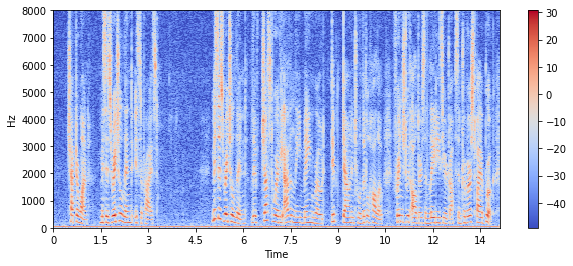

In [9]:
data_1 = train_dataset[0]
exploreData(data_1)

Steps:

1. Prepare dataset
    1.1 Load dataset
    1.2 Make a dataloader with the dataset
        1.2.1 Convert each data by data_processing function
    1.3 Define a model
        1.3.1 Load a model
        1.3.2 define a optimizer (activation function)
        1.3.3 Define a criterion (loss function)
        1.3.4 Define a scheduler for leraning rate
    1.4 Train
    1.5 Test


# 2. Preprocessing

## 2_1. Text Transformation
Map the character labels for each audio sample into integer labels

In [16]:
char_map_str = """
 ' 0
 <SPACE> 1
 a 2
 b 3
 c 4
 d 5
 e 6
 f 7
 g 8
 h 9
 i 10
 j 11
 k 12
 l 13
 m 14
 n 15
 o 16
 p 17
 q 18
 r 19
 s 20
 t 21
 u 22
 v 23
 w 24
 x 25
 y 26
 z 27
 """

class TextTransform:
    """ Maps Characters -> Integers and vice versa"""
    def __init__(self):
        global char_map_str
        self.char2index = {}
        self.index2char = {}
        for line in char_map_str.strip().split('\n'):
            char, index = line.split()
            self.char2index[char] = int(index)
            self.index2char[int(index)] = char
        self.index2char[1] = ' '

    def text_to_int(self, text):
        """ Convert text into an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char2index['<SPACE>']
            else:
                ch = self.char2index[c]
            int_sequence.append(ch)
        return int_sequence
    
    def int_to_text(self, labels):
        """ Convert integer labels to a text sequenc """
        text = []
        for i in labels:
            text.append(self.index2char[i])
        return ''.join(text).replace('<SPACE>', ' ')

text_transform = TextTransform()

## 2_2. Audio Transformation

Transform the audio into MelSpectrogram and apply Frequency masking and Time masking for data augmentation

In [17]:
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate = 16000, n_mels = 128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35)
)

valid_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate = 16000, n_mels = 128)
)

In [22]:
def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths


In [23]:
waveform, _, utterance, _, _, _ = data_1
print(f"Waveform has shape of : {waveform.shape}")

Waveform has shape of : torch.Size([1, 225360])


In [24]:
spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
print(f"Transformed audio has shape of {spec.shape}")

Transformed audio has shape of torch.Size([1127, 128])


In [25]:
label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
print("Labels will be transformed as shown below (characters -> mapped integers")
print(f"Original Utterance has a length of {len(utterance)} while Transformed label has the same length of {len(label)}")
print(label)


Labels will be transformed as shown below (characters -> mapped integers
Original Utterance has a length of 201 while Transformed label has the same length of 201
tensor([ 4.,  9.,  2., 17., 21.,  6., 19.,  1., 16., 15.,  6.,  1., 14., 10.,
        20., 20., 22., 20.,  1., 19.,  2.,  4.,  9.,  6., 13.,  1., 13., 26.,
        15.,  5.,  6.,  1., 10., 20.,  1., 20., 22., 19., 17., 19., 10., 20.,
         6.,  5.,  1., 14., 10., 20., 20., 22., 20.,  1., 19.,  2.,  4.,  9.,
         6., 13.,  1., 13., 26., 15.,  5.,  6.,  1., 13., 10., 23.,  6.,  5.,
         1., 11., 22., 20., 21.,  1., 24.,  9.,  6., 19.,  6.,  1., 21.,  9.,
         6.,  1.,  2., 23., 16., 15., 13.,  6.,  2.,  1., 14.,  2., 10., 15.,
         1., 19., 16.,  2.,  5.,  1.,  5., 10., 17., 17.,  6.,  5.,  1.,  5.,
        16., 24., 15.,  1., 10., 15., 21., 16.,  1.,  2.,  1., 13., 10., 21.,
        21., 13.,  6.,  1.,  9., 16., 13., 13., 16., 24.,  1.,  7., 19., 10.,
        15.,  8.,  6.,  5.,  1., 24., 10., 21.,  9.,  1.,

# 3. Models

## 3_1. Build Models

### 3_1_1. Improved model of Deep Speech 2 (23,705,373 parameters)
from https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch/

Spectrogram -> N Residual Conv Layer -> Linear Layer -> N Bidirectional GRU Layer -> N Linear Layer -> Softmax -> Argmax to select the most probable one -> Decoding -> "Hello World"

1. Use Residual Convolutional layer rather than just vanilla Convolutional layer making the model generalize faster and better.
2. The paper Visualizing the Loss Landscape of Neural Nets shows that networks with residual connections have a “flatter” loss surface, making it easier for models to navigate the loss landscape and find a lower and more generalizable minima

In [26]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 

class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)
        
class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

### 3_1_2. Improved model of DS2 with Depthwise Separable Convolution

In [ ]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 

class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, nout, kernel_size = 3, stride = 1, padding = 1, bias=False):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=kernel_size, padding=padding, stride=stride, groups=nin, bias=bias)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = depthwise_separable_conv(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = depthwise_separable_conv(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)
        
class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel_dsc(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel_dsc, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

## 3_2. Training and Evaluating Functions

In [27]:
import numpy as np

def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)

def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in char-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Levenshtein distance and length of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words substituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text in char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    We can use levenshtein distance to calculate CER. Chinese input should be
    encoded to unicode. Please draw an attention that the leading and tailing
    space characters will be truncated and multiple consecutive space
    characters in a sentence will be replaced by one space character.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Character error rate.
    :rtype: float
    :raises ValueError: If the reference length is zero.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

In [28]:
def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

In [29]:
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val

## 3_2. Experiment if the current model works with a batch

In [ ]:
learning_rate=5e-4
batch_size=16
epochs=1
train_url="train-clean-100"
test_url="test-clean"

hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 5,
        "rnn_dim": 256,
        "n_class": 29,
        "n_feats": 128,
        "stride": 2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
}

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = DataLoader(dataset=train_dataset,
                            batch_size=hparams['batch_size'],
                            shuffle=True,
                            collate_fn=lambda x: data_processing(x, 'train'),
                            **kwargs)
test_loader = DataLoader(dataset=test_dataset,
                            batch_size=hparams['batch_size'],
                            shuffle=False,
                            collate_fn=lambda x: data_processing(x, 'valid'),
                            **kwargs)

Why CTCLoss? </br>
1. CTC Loss Function aligns audio to transcript. Traditional speech recognition models would require you to align the transcript text to the audio before training, and the model would be trained to predict specific labels at specific frames.

2. The innovation of the CTC loss function is that it allows us to skip this step. Our model will learn to align the transcript itself during training. The key to this is the “blank” label introduced by CTC, which gives the model the ability to say that a certain audio frame did not produce a character. 

Why AdamW and OneCycleLR?
1. Adam is widely used optimizer that helps your model converge more quickly. It has a cons that it does not generalize as well as Stochastic Gradient Descent AKA SGD. AdamW was developed to fix the original Adan's wrong impelementation of Weight Decay. This fix helps with Adam's generalization problem.
2. One Cycle Learning Rate Scheduler can train the neural nets an order of magnitude faster, while keeping their generalizable abilities by staring with low learning rate, warming up to a large maximum learning rate, then decays linearly to the same point of wehre originally started.

In [58]:
class Config(object):
    def __init__(self):
        # Load Dataset
        self.train_url="train-clean-100"
        self.test_url="test-clean"
        
        # Training parameters
        self.n_cnn_layers = 3
        self.n_rnn_layers = 7
        self.rnn_dim= 512
        self.n_class= 29
        self.n_feats = 128
        self.stride = 2 
        self.dropout = 0.2
        self.learning_rate = 5e-4
        self.train_batch_size = 32
        self.val_batch_size = 4
        self.epochs = 6
        
        # Model and Result
        self.model_path = './LibriSpeech_ImprovedDS2_20221109.pt'
        self.res_path = './LibriSpeech_ImprovedDS2_20221109.pkl'


In [59]:
config = Config()

In [60]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = DataLoader(dataset=train_dataset,
                        batch_size= config.train_batch_size,
                        shuffle = True,
                        collate_fn=lambda x: data_processing(x, 'train'),
                        **kwargs)
test_loader = DataLoader(dataset=test_dataset,
                        batch_size= config.val_batch_size,
                        shuffle = False,
                        collate_fn=lambda x: data_processing(x, 'valid'),
                        **kwargs)

In [61]:
a_train_loader = next(iter(train_loader))

In [62]:
model = SpeechRecognitionModel(
    config.n_cnn_layers,
    config.n_rnn_layers,
    config.rnn_dim,
    config.n_class,
    config.n_feats,
    config.stride,
    config.dropout
    ).to(device)

print('Number of Model Parameters', sum([param.nelement() for param in model.parameters()]))

optimizer = torch.optim.AdamW(model.parameters(), config.learning_rate)
criterion = nn.CTCLoss(blank=28).to(device)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config.learning_rate, 
                                        steps_per_epoch=int(len(train_loader)),
                                        epochs=config.epochs,
                                        anneal_strategy='linear')

iter_meter = IterMeter()

Number of Model Parameters 33158941


In [63]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters", "Consec.Params"])
    total_params = 0
    consec_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        consec_params += params
        table.add_row([name, params, consec_params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+-----------------------------------------------+------------+---------------+
|                    Modules                    | Parameters | Consec.Params |
+-----------------------------------------------+------------+---------------+
|                   cnn.weight                  |    288     |      288      |
|                    cnn.bias                   |     32     |      320      |
|          rescnn_layers.0.cnn1.weight          |    9216    |      9536     |
|           rescnn_layers.0.cnn1.bias           |     32     |      9568     |
|          rescnn_layers.0.cnn2.weight          |    9216    |     18784     |
|           rescnn_layers.0.cnn2.bias           |     32     |     18816     |
| rescnn_layers.0.layer_norm1.layer_norm.weight |     64     |     18880     |
|  rescnn_layers.0.layer_norm1.layer_norm.bias  |     64     |     18944     |
| rescnn_layers.0.layer_norm2.layer_norm.weight |     64     |     19008     |
|  rescnn_layers.0.layer_norm2.layer_norm.bias  |   

33158941

In [64]:
spectrograms, labels, input_lengths, label_lengths = a_train_loader 
spectrograms, labels = spectrograms.to(device), labels.to(device)

# Forward
output = model(spectrograms)
output = F.log_softmax(output, dim=2)
output = output.transpose(0, 1)

loss = criterion(output, labels, input_lengths, label_lengths)

# Backward
optimizer.zero_grad()
loss.backward()
print(loss)
# Update weights
optimizer.step()
scheduler.step()
iter_meter.step()

tensor(7.0750, device='cuda:0', grad_fn=<MeanBackward0>)


#4. Run Experiment (train and test)

## 4_1. Define functions for train and test

In [65]:
def train_and_validate(model, device, train_loader, val_loader, criterion, optimizer, scheduler, epochs, iter_meter):
    res = {}
    res['train'] = {}
    res['train']['loss'] = []
    res['train']['cer'] = [] 
    res['train']['wer'] = []   
    res['val'] = {}
    res['val']['loss'] = []
    res['val']['cer'] = [] 
    res['val']['wer'] = []   

    data_len = len(train_loader.dataset)

    for epoch in range(1, epochs+1):
        print(f"\nEpoch {epoch}/{epochs}")
        print("Training...")
        model.train()
        train_loss = 0
        train_cer, train_wer = [], []

        for batch_idx, _data in enumerate(train_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward
            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            # Evaluate
            loss = criterion(output, labels, input_lengths, label_lengths)
            train_loss += loss.item() / len(train_loader)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            for j in range(len(decoded_preds)):
                train_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                train_wer.append(wer(decoded_targets[j], decoded_preds[j]))

            # Backward
            loss.backward()

            # Gradient Descent
            optimizer.step()
            scheduler.step()
            iter_meter.step()
            
            if batch_idx % 100 == 0 or batch_idx == data_len:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(spectrograms), data_len,
                    100. * batch_idx / len(train_loader), loss.item()))
      
        avg_cer = sum(train_cer) / len(train_cer)
        avg_wer = sum(train_wer) / len(train_wer)
        # Record the result
        res['train']['loss'].append(train_loss)
        res['train']['cer'].append(avg_cer)
        res['train']['wer'].append(avg_wer)
        print('Train set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(train_loss, avg_cer, avg_wer))         
        
        print("\nValidating...")
        model.eval()
        test_loss = 0
        test_cer, test_wer = [], []
        with torch.no_grad():
            for batch_idx, _data in enumerate(val_loader):
                spectograms, labels, input_lengths, label_lengths = _data
                spectograms, labels = spectograms.to(device), labels.to(device)

                # Forward
                output = model(spectograms) # (batch, time, n_class)
                output = F.log_softmax(output, dim=2)
                output = output.transpose(0, 1) #(time, batch, n_class)

                # Evaluate
                loss = criterion(output, labels, input_lengths, label_lengths)
                test_loss += loss.item() / len(val_loader)

                decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
                for j in range(len(decoded_preds)):
                    test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                    test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

        avg_cer = sum(test_cer) / len(test_cer)
        avg_wer = sum(test_wer) / len(test_wer)
        # Record the result
        res['val']['loss'].append(test_loss)
        res['val']['cer'].append(avg_cer)
        res['val']['wer'].append(avg_wer)
        print('Validation set: Average CER: {:4f} Average WER: {:.4f}\n'.format(avg_cer, avg_wer))         
        
    return res, model


## 4_2. Run an experiment

In [66]:
def main(config):
    # Initialize
    ## Input
    train_url = config.train_url
    test_url = config.test_url
    train_batch_size = config.train_batch_size
    val_batch_size = config.val_batch_size
    ## Model
    n_cnn_layers = config.n_cnn_layers
    n_rnn_layers = config.n_rnn_layers
    rnn_dim = config.rnn_dim
    n_class = config.n_class
    n_feats = config.n_feats
    stride = config.stride
    dropout = config.dropout
    learning_rate = config.learning_rate
    epochs = config.epochs
    ## Results
    model_path = config.model_path
    res_path = config.res_path

    # Prepare Data
    use_cuda = torch.cuda.is_available()
    torch.manual_seed(7)
    device = torch.device("cuda" if use_cuda else "cpu")
    print(f"Using {device}")

    train_dataset = torchaudio.datasets.LIBRISPEECH("./", url=train_url, download=True)
    val_dataset = torchaudio.datasets.LIBRISPEECH("./", url=test_url, download=True)

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = DataLoader(dataset=train_dataset,
                                batch_size=train_batch_size,
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x, 'train'),
                                **kwargs)
    val_loader = DataLoader(dataset=val_dataset,
                                batch_size=val_batch_size,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'val'),
                                **kwargs)

    iter_meter = IterMeter()

    # Prepare Model
    model = SpeechRecognitionModel(
        n_cnn_layers = n_cnn_layers, 
        n_rnn_layers = n_rnn_layers,
        rnn_dim = rnn_dim,
        n_class = n_class,
        n_feats = n_feats,
        stride = stride,
        dropout = dropout
        ).to(device)

    print('Number of Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = torch.optim.AdamW(model.parameters(), learning_rate)
    criterion = nn.CTCLoss(blank=28).to(device)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=epochs,
                                            anneal_strategy='linear')

    iter_meter = IterMeter()
    start_time = time.time()

    # Train and Validate the Model
    res, model = train_and_validate(model, device, train_loader, val_loader, criterion, optimizer, scheduler, epochs, iter_meter)
    res['config'] = config
    res['model'] = model_path 
    
    elapsed_time_secs = time.time() - start_time
    msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))
    print(msg)

    # Save model
    torch.save(model.state_dict(), model_path)
    # Save result in pickle
    with open(res_path, 'wb') as f:
        pickle.dump(res, f)

    # Loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(list(range(1, epochs+1)), res['train']['loss'], label='Train')
    plt.plot(list(range(1, epochs+1)), res['val']['loss'], label='Val')
    plt.legend(loc='upper right')
    plt.title('Loss plot')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    # CER plot
    plt.figure(figsize=(10, 5))
    plt.plot(list(range(1, epochs+1)), res['train']['cer'], label='Train')
    plt.plot(list(range(1, epochs+1)), res['val']['cer'], label='Val')
    plt.legend(loc='upper right')
    plt.title('CER plot')
    plt.xlabel('Epochs')
    plt.ylabel('CER')
    plt.show()

    # WER plot
    plt.figure(figsize=(10, 5))
    plt.plot(list(range(1, epochs+1)), res['train']['wer'], label='Train')
    plt.plot(list(range(1, epochs+1)), res['val']['wer'], label='Val')
    plt.legend(loc='upper right')
    plt.title('WER plot')
    plt.xlabel('Epochs')
    plt.ylabel('WER')
    plt.show()

Using cuda
Number of Model Parameters 33158941

Epoch 1/6
Training...
Train Epoch: 1 [0/28539 (0%)]	Loss: 6.956928
Train Epoch: 1 [3200/28539 (11%)]	Loss: 2.877821
Train Epoch: 1 [6400/28539 (22%)]	Loss: 2.921547
Train Epoch: 1 [9600/28539 (34%)]	Loss: 2.868245
Train Epoch: 1 [12800/28539 (45%)]	Loss: 2.881113
Train Epoch: 1 [16000/28539 (56%)]	Loss: 2.890429
Train Epoch: 1 [19200/28539 (67%)]	Loss: 2.861662
Train Epoch: 1 [22400/28539 (78%)]	Loss: 2.855409
Train Epoch: 1 [25600/28539 (90%)]	Loss: 2.849990
Train set: Average loss: 2.9430, Average CER: 1.004488 Average WER: 0.9995


Validating...
Validation set: Average CER: 0.985333 Average WER: 1.0000


Epoch 2/6
Training...
Train Epoch: 2 [0/28539 (0%)]	Loss: 2.840794
Train Epoch: 2 [3200/28539 (11%)]	Loss: 2.865381
Train Epoch: 2 [6400/28539 (22%)]	Loss: 2.861843
Train Epoch: 2 [9600/28539 (34%)]	Loss: 2.812482
Train Epoch: 2 [12800/28539 (45%)]	Loss: 2.667499
Train Epoch: 2 [16000/28539 (56%)]	Loss: 2.374761
Train Epoch: 2 [19200/2

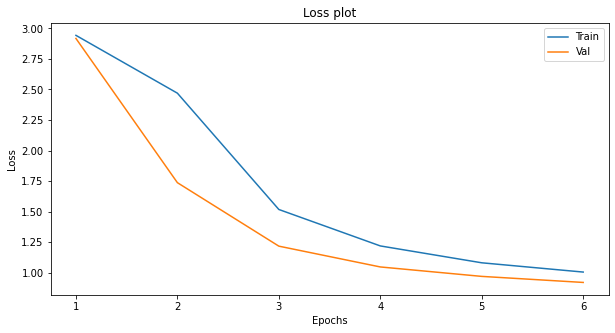

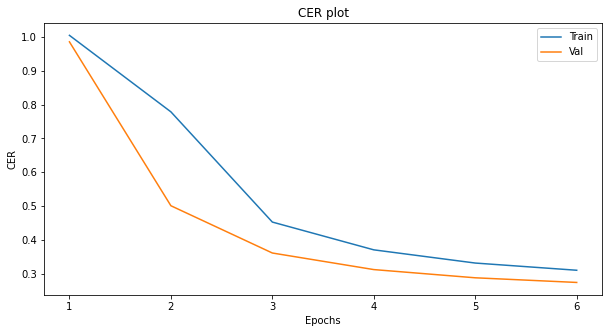

KeyError: ignored

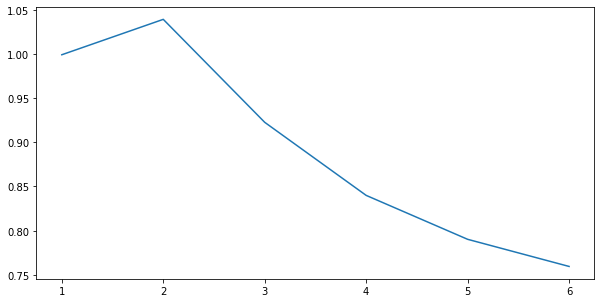

In [67]:
main(config)

The recent technique for speech recognition
1. WER 1.4: Conformer + Wav2vec 2.0 + SpecAugment-based Noisy Student Training with Libri-Light
2. WER 1.4: w2v-BERT XXL
3. WER 1.5: Conv + Transformer + wav2vec2.0 + pseudo labeling
4. WER 1.7: ContextNet + SpecAugment-based Noisy Student Training with Libri-Light

In [71]:
model_path = config.model_path
res_path = config.res_path
print(model_path)
print(res_path)

./LibriSpeech_ImprovedDS2_20221109.pt
./LibriSpeech_ImprovedDS2_20221109.pkl


#5. Generate an text from an audio file using trained model

In [81]:
# Prepare an audio file
data_1 = test_dataset[0]

speaker_id = str(data_1[3])
chapter_id = str(data_1[4])
utterance_id = str(data_1[5])

test_path = './LibriSpeech/test-clean'
file_numbering = '0'*(4-len(utterance_id)) + utterance_id
file_path = test_path + f'/{speaker_id}/{chapter_id}/{speaker_id}-{chapter_id}-{file_numbering}.flac'
# File Path is the the file address
print(file_path)
display(Audio(filename = file_path))
print(data_1[2])

./LibriSpeech/test-clean/1089/134686/1089-134686-0000.flac


HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE


In [73]:
# Preprocess the audio file
waveform, sample_rate = torchaudio.load(file_path)
print(f"waveform shape: {waveform.shape}")
print(f"sample_rate: {sample_rate}")
spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1).unsqueeze(0).unsqueeze(1).transpose(2, 3)

waveform shape: torch.Size([1, 166960])
sample_rate: 16000


In [76]:
import pickle

# open a file, where you stored the pickled data
file = open('./LibriSpeech_ImprovedDS2_20221109.pkl', 'rb')
# dump information to that file
loaded_data = pickle.load(file)
# close the file
file.close()

In [85]:
# Initialize
config = loaded_data['config']
## Input
test_url = config.test_url
train_batch_size = config.train_batch_size
val_batch_size = config.val_batch_size
## Model
n_cnn_layers = config.n_cnn_layers
n_rnn_layers = config.n_rnn_layers
rnn_dim = config.rnn_dim
n_class = config.n_class
n_feats = config.n_feats
stride = config.stride
dropout = config.dropout
learning_rate = config.learning_rate
epochs = config.epochs
## Results
model_path = config.model_path
res_path = config.res_path

# Initial setup
use_cuda = torch.cuda.is_available()
torch.manual_seed(7)
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using {device}")

Using cuda


In [90]:
# Prepare Model
model = SpeechRecognitionModel(
    n_cnn_layers = n_cnn_layers, 
    n_rnn_layers = n_rnn_layers,
    rnn_dim = rnn_dim,
    n_class = n_class,
    n_feats = n_feats,
    stride = stride,
    dropout = dropout
    ).to(device)

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
spec = spec.to(device)

In [91]:
import re

blank_label = 28
collapse_repeated=True

with torch.no_grad():
    decode = []
    output = model(spec)
    sqeezed_output = output.squeeze(0)
    arg_max = torch.argmax(sqeezed_output, dim=1)
    for j, index in enumerate(arg_max):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == arg_max[j -1]:
                    continue
                decode.append(index.item())
pred_text = text_transform.int_to_text(decode)
# Replace two or more spaces with one
pred_text = re.sub('\s{2,}', ' ', pred_text)
print(f"Original  Text: {data_1[2]}")
print(f"Predicted Text: {pred_text}")

Original  Text: HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE
Predicted Text: he hoped there would be sto hor diner terneps and caret sand brused bu tat hos and faten muten peces to bedlatledoutan totick ppepered foer facpen sos 
